<a href="https://colab.research.google.com/github/wandieinnocents/diagnosing_ultrasound_image_DeepLearning/blob/main/chest_opaciy_Deep_learningv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>MASTER OF SCIENCE IN COMPUTER SCIENCE</center></h1>
<p><center>DEEP LEARNING , SEMESTER 2 | ASSIGNMENT 1 </center></p>
<p><center><strong> NAME  : WENAREEBA INNOCENT | REG-NO: 2021/HD05/2315U | STUDENT NO : 2100702315</strong></center></p>


<center><h2><b>ULTRA SOUND IMAGE SCAN DEEP LEARNING BASED MODEL</b></h2>

Implementation of a Deep Learning model capable of diagnosing an ultrasound image scan as normal or as having a chest opacity.</center>

In [1]:
# Import libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds
import glob
from google.colab import drive
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras


In [2]:
# tensorflow version
print(tf.__version__)

2.8.2


In [3]:
# mount the google drive to use its resources
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
# import dataset
import pathlib
# pick the dataset from the drive folder
dataset_one = "/content/gdrive/MyDrive/deep_learning/dataset1/known_images"
# training dataset
training_dataset = tf.keras.utils.image_dataset_from_directory(dataset_one,validation_split=0.25, subset="training",seed=123,image_size=(100,100),batch_size=20)

Found 715 files belonging to 2 classes.
Using 537 files for training.


In [5]:
# validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset_one, validation_split=0.05,subset="validation",seed=123, image_size=(100,100),batch_size=20)

Found 715 files belonging to 2 classes.
Using 35 files for validation.


In [6]:
# Testing dataset
testing_dataset = tf.keras.utils.image_dataset_from_directory(dataset_one, validation_split=0.2,subset="validation",seed=123, image_size=(100,100),batch_size=20)

Found 715 files belonging to 2 classes.
Using 143 files for validation.


In [7]:
# Show class names
display_class_names = training_dataset.class_names
# print class names
print(display_class_names)

['normal', 'sick']


Visualization of the  the dataset
This shows 12 images from the training dataset

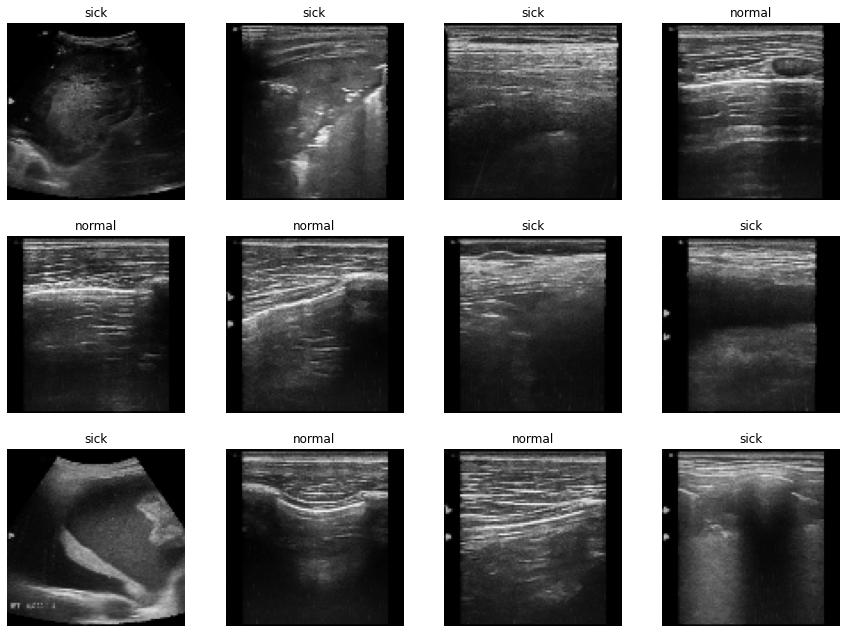

In [8]:
# plot the image datasets
# resize the plot to display
plt.figure(figsize=(15,15))
for images_data,labels in training_dataset.take(1):
  for image in range(12):
    ax = plt.subplot(4,4, image+1)
    plt.imshow(images_data[image].numpy().astype("uint8"))
    plt.title(display_class_names[labels[image]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(20, 100, 100, 3)
(20,)


Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Standardize the data By normalization

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [11]:
normalization_layer = layers.Rescaling(1./255)


In [12]:
# normalized training dataset
normalized_ds = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9822354


In [13]:
# normalized validation dataset
normalized_validation_ds = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_validation_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.9750608


Create the model

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [14]:
num_classes = len(display_class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


Compile the model

using tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model summary

View all the layers of the network using the model's Model.summary method:

In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

Train the model

In [17]:
epochs=10
history = model.fit(
  # normalized training dataset
  normalized_ds,
  validation_data=normalized_ds,
  epochs=epochs
)

# epochs=10
# history = model.fit(
# normalized_train_ds, 
# validation_data =normalized_train_ds,
# epochs=epochs
# )

Epoch 1/10
27/27 [==============================] - 13s 444ms/step - loss: 0.6972 - accuracy: 0.5177 - val_loss: 0.6927 - val_accuracy: 0.5196
Epoch 2/10
27/27 [==============================] - 6s 234ms/step - loss: 0.6928 - accuracy: 0.5196 - val_loss: 0.6926 - val_accuracy: 0.5196
Epoch 3/10
27/27 [==============================] - 6s 232ms/step - loss: 0.6932 - accuracy: 0.5196 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 4/10
27/27 [==============================] - 6s 233ms/step - loss: 0.6926 - accuracy: 0.5196 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 5/10
27/27 [==============================] - 6s 235ms/step - loss: 0.6926 - accuracy: 0.5196 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 6/10
27/27 [==============================] - 6s 235ms/step - loss: 0.6927 - accuracy: 0.5196 - val_loss: 0.6923 - val_accuracy: 0.5196
Epoch 7/10
27/27 [==============================] - 6s 236ms/step - loss: 0.6924 - accuracy: 0.5196 - val_loss: 0.6920 - val_accuracy: 0.5196
Epoch

Visualize training results
Create plots of loss and accuracy on the training and validation sets:

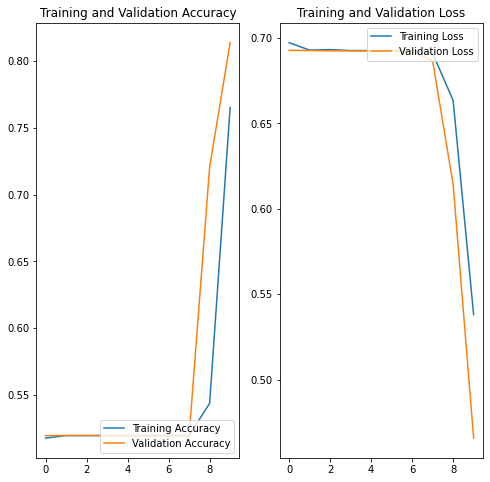

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

**Data augmentation to reduce overfitting**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


In [19]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

You will use data augmentation to train a model in a moment.

Dropout

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [20]:
# create second model
num_classes = len(display_class_names)

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



Compile and train the model

In [21]:
# i use adam since it provides more accuracy
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)       

In [23]:
epochs = 15
history1 = model2.fit(
  # training_dataset,
  validation_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)


Epoch 1/15
2/2 [==============================] - 1s 407ms/step - loss: 0.7143 - accuracy: 0.5143 - val_loss: 0.5961 - val_accuracy: 0.6000
Epoch 2/15
2/2 [==============================] - 0s 264ms/step - loss: 0.6093 - accuracy: 0.6857 - val_loss: 0.5783 - val_accuracy: 0.9143
Epoch 3/15
2/2 [==============================] - 0s 257ms/step - loss: 0.5598 - accuracy: 0.9143 - val_loss: 0.4816 - val_accuracy: 0.8286
Epoch 4/15
2/2 [==============================] - 0s 272ms/step - loss: 0.4667 - accuracy: 0.8000 - val_loss: 0.4160 - val_accuracy: 0.7429
Epoch 5/15
2/2 [==============================] - 0s 272ms/step - loss: 0.4006 - accuracy: 0.7429 - val_loss: 0.3149 - val_accuracy: 0.8857
Epoch 6/15
2/2 [==============================] - 0s 259ms/step - loss: 0.3170 - accuracy: 0.8857 - val_loss: 0.2589 - val_accuracy: 0.9143
Epoch 7/15
2/2 [==============================] - 0s 268ms/step - loss: 0.2370 - accuracy: 0.9143 - val_loss: 0.2050 - val_accuracy: 0.9143
Epoch 8/15
2/2 [====

Visualize training results

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

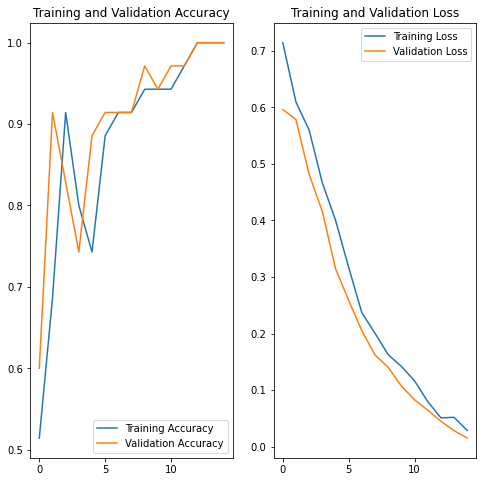

In [24]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Predict on new data (Unkwown dataset)

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [25]:
# dataset_url_to_predict = "/content/gdrive/MyDrive/deep_learning/dataset1/unknown_images/1.png"
# dataset_url_to_predict = "/content/gdrive/MyDrive/deep_learning/dataset1/known_images/normal/normal_0.png"
# dataset_url_to_predict = "/content/gdrive/MyDrive/deep_learning/dataset1/known_images/sick/sick_0.png"

# Testing single image
dataset_1_image_prediction = "/content/gdrive/MyDrive/deep_learning/dataset1/unknown_images/17.png"

img = tf.keras.utils.load_img(dataset_1_image_prediction, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is likely to belong to  {} class, with a {:.2f} percent confidence"
    .format(display_class_names[np.argmax(score)], 100*np.max(score))
)

This image is likely to belong to  normal class, with a 100.00 percent confidence


Fetching paths for Unknown dataset to print array of images
Predict data on unknown datasets, dataset1

In [26]:
# Fetching paths for dataset 2 to print array of images
# Predict data on dataset2 dataset
# Testing Multiple  images  
dataset_two_path = "/content/gdrive/MyDrive/deep_learning/dataset2"
test_dataset_2 = tf.keras.utils.image_dataset_from_directory(dataset_two_path, image_size=(100,100),batch_size=20)


Found 227 files belonging to 1 classes.


Predictions: 
 [0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1]
Labels:
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


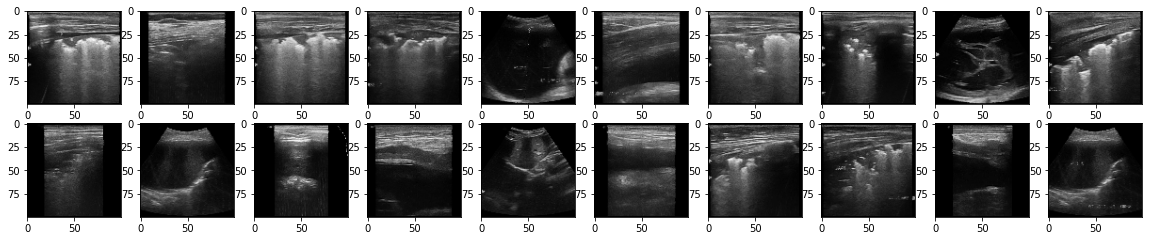

In [27]:

import pandas as pd  
import numpy as np
import csv

image_batch,label_batch = test_dataset_2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.math.argmax(predictions,1)
print('Predictions: \n', predictions.numpy())
print('Labels:\n ', label_batch)  

plt.figure(figsize=(20,10))
for i in range(20):
    ax = plt.subplot(5,10,i+1)
    plt.imshow(image_batch[i].astype("uint8"))


GENERATE DATA TO CSV FOR (UNKNOWN DATASET)- DATASET 1

In [28]:
# unknown dataset csv

Predict on new data (Dataset 2)

In [29]:
# Predict on dataset1
# Testing Single image
dataset_2_image_prediction = "/content/gdrive/MyDrive/deep_learning/dataset2/images/sick_eff101.png"

img = tf.keras.utils.load_img(dataset_2_image_prediction, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is likely to belong to  {} class ,with a {:.2f} percent confidence"
    .format(display_class_names[np.argmax(score)], 100*np.max(score))
)

This image is likely to belong to  sick class ,with a 100.00 percent confidence


Fetching paths for dataset 2 to print array of images
 Predict data on dataset2

In [30]:
# Fetching paths for dataset 2 to print array of images
# Predict data on dataset2 dataset
# Testing Multiple  images  
dataset_two_path = "/content/gdrive/MyDrive/deep_learning/dataset2"
test_dataset_2 = tf.keras.utils.image_dataset_from_directory(dataset_two_path, image_size=(100,100),batch_size=20)


Found 227 files belonging to 1 classes.


Predictions: 
 [1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1]
Labels:
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


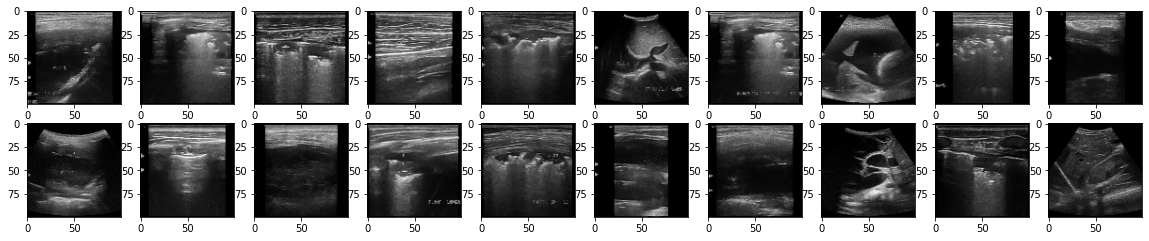

In [31]:

image_batch,label_batch = test_dataset_2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.math.argmax(predictions,1)
print('Predictions: \n',  predictions.numpy())
print('Labels:\n ', label_batch)

plt.figure(figsize=(20,10))
for i in range(20):
    ax = plt.subplot(5,10,i+1)
    plt.imshow(image_batch[i].astype("uint8"))



In [32]:
import pandas as pd
import numpy as np
DF = pd.DataFrame(predictions)
DF.to_csv("/content/gdrive/MyDrive/deep_learning/dataset2/image_results_3.csv")




In [33]:
# METRICS
# confusion matrix
tf.math.confusion_matrix(
    label_batch,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 9, 11],
       [ 0,  0]], dtype=int32)>